In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import re
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import music21
import math

torch.manual_seed(1)

In [2]:
from music21 import *
# change path to location of uncorrected songs
path = "/Users/antonischristou/Downloads/Wikifonia"
songs = []

i = 0
for filename in os.listdir(path):
    song_path = path+"/"+filename+"/"
    try:
        song = converter.parse(song_path)
    except:
        print("an error of some kind occured...")
    else:
        songs.append(song)
        print(i)
        i += 1

print(f"Captured {len(songs)} songs ")

0
1
2
3
an error of some kind occured...
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
an error of some kind occured...
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
an error of some kind occured...
64
65
66
67
68
69
70
71
72
73
74
75
76
77
an error of some kind occured...
78
79
an error of some kind occured...
80
81
82
an error of some kind occured...
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
an error of some kind occured...
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
an error of some kind occured...
an error of some kind occured...
156
157
an error of some kind occured...
158
159
160
161
162
163
164
165
166
an error of some kind occured...
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186

In [3]:
songs[0].parts.stream().flat

<music21.stream.Score 0x47af2e090_flat>

In [4]:
# filter to only 2/4 or 4/4 songs and songs with no chords

filtered = []
i = 0
for song in songs:

  main_parts = song.parts.stream()
  flat_part = main_parts.flat

  timeSig = flat_part.timeSignature

  chords = flat_part.getElementsByClass('Chord')

  if timeSig != None:
    if (timeSig.ratioString == "4/4" or timeSig.ratioString == "2/4" or timeSig.ratioString == "2/2") and len(chords) > 0:
      filtered.append(song)
    else:
      print("Filtered out time sig of", timeSig.ratioString)
  else:
    print("no time sig?",i)
    i+= 1
  
print("Filtered out: ",len(songs)-len(filtered), "songs")
print("Now have: ",len(filtered), "songs")
songs = filtered



Filtered out time sig of 3/4
Filtered out time sig of 4/4
Filtered out time sig of 3/4
Filtered out time sig of 4/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 2/4
Filtered out time sig of 4/4
Filtered out time sig of 3/4
Filtered out time sig of 2/4
Filtered out time sig of 12/8
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 4/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 4/4
Filtered out time sig of 3/4
Filtered out time sig of 4/4
Filtered out time sig of 6/8
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 6/8
Filtered out time sig of 3/4
Filtered out time sig of 6/8
Filtered out time sig of 4/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out time sig of 3/4
Filtered out 

Round every chord to nearest half beat 
concept is: if measure has chord on beats 1 or 3 already, ignore other chords
if not, snap chord to closest 1 or 3 beat

In [5]:
from fractions import Fraction
import copy 

y = 0
z = 0


def fix_measure(m,measures):
    chords = m.getElementsByClass("ChordSymbol")
    offsets = [chord.offset for chord in chords]
    toRemove = []

    # best case: in this case, we have all the chords we need so we ignore the rest
    if (timeSig.ratioString == "2/4" and 0.0 in offsets) or (0.0 in offsets and 2.0 in offsets):
        # if chords remain, delete them 
        if len(chords) > 2 or (timeSig.ratioString == "2/4" and len(chords) > 1):

            # print("print pre fix: ")
            # print(m.show("text"))

         #   print("changed MADE HERE ADjskffjkgsfgsiujgksgssgksgsgjggssssgshjgsskghghsbjssjkbfvf")
            toRemove = [chord for chord in chords if chord.offset != 0.0 and chord.offset != 2.0]

            # if multiple chords exist on offset 0,2, delete extras by selecting first TODO NOTE: this will cause some issues as some pedal chords etc will remain deleting actual
            onDownBeats = [chord for chord in chords if chord.offset == 0]
            onHalfBeats = [chord for chord in chords if chord.offset == 2]

            if len(onDownBeats) > 1:
                for extraChord in onDownBeats[1:]:
                    toRemove.append(extraChord)
            if len(onHalfBeats) > 1:
                for extraChord in onHalfBeats[1:]:
                    toRemove.append(extraChord)
            
            # print(toRemove)

            m.remove(toRemove, shiftOffsets=False)

            # print("post fix ")
            # m.show("text")
    # if we have a downbeat chord but NOT a half beat chord, snap nearest chord to half beat, delete rest
    elif 0.0 in offsets and len(chords) > 1: 
        
        # print(" pre half bar fix: ")
        # print(m.show("text"))
        nearestDistance = float('inf')
        nearestChordToHalf = None
        for chord in chords:
            if abs(2.0-chord.offset) < nearestDistance and chord.offset != 0.0:
                nearestDistance = abs(2.0-chord.offset)
                nearestChordToHalf = chord

        if nearestChordToHalf:
            copiedChord = copy.deepcopy(nearestChordToHalf)
            m.insert(2.0,copiedChord)
        #print("ncth", nearestChordToHalf)
        toRemove = [chord for chord in chords if chord.offset != 0.0 and chord.offset != 2.0]

        # possible case: multiple chords on downbeat, none elsewhere, delete extra copy chord 
        onDownBeats = [chord for chord in chords if chord.offset == 0]
        if len(onDownBeats) > 1:
            for extraChord in onDownBeats[1:]:
                toRemove.append(extraChord)
        

        m.remove(toRemove, shiftOffsets=False)
        # if no chord passed, copy chord at downbeat, insert at half
        if not nearestChordToHalf:
            # copy chord at beginning and insert at half 
            copiedChord = copy.deepcopy(chords[0])
            m.insert(2.0, copiedChord)


        # print("have downbeat chord,others elsewhere and need half")
        # print(nearestChordToHalf,nearestDistance)
        # print(toRemove)
    
    # we have only downbeat chord, need to duplicate it at half bar 
    elif 0.0 in offsets and len(chords) == 1: 
        
        # copy chord at beginning and insert at half 
        copiedChord = copy.deepcopy(chords[0])
        m.insert(2.0, copiedChord)

        # print("only chord is on downbeat case")
    # we only have chord on half beat case 
    elif 2.0 in offsets and len(chords) > 1: 
        
        # print(" pre half bar fix: ")
        # print(m.show("text"))
        nearestDistance = float('inf')
        nearestChordToDown = None
        for chord in chords:
            if abs(0-chord.offset) < nearestDistance and chord.offset != 2.0:
                nearestDistance = abs(0-chord.offset)
                nearestChordToDown = chord

        if nearestChordToDown:
            copiedChord = copy.deepcopy(nearestChordToDown)
            m.insert(0,copiedChord)

        toRemove = [chord for chord in chords if chord.offset != 0.0 and chord.offset != 2.0]

        # possible case: multiple chords on half beat, none elsewhere, delete extra copy chord 
        onHalfBeats = [chord for chord in chords if chord.offset == 2.0]
        if len(onHalfBeats) > 1:
            for extraChord in onHalfBeats[1:]:
                toRemove.append(extraChord)
        
        m.remove(toRemove, shiftOffsets=False)
        # if no chord passed, copy chord at halfbeat, insert at down
        if not nearestChordToDown:
            # copy chord at beginning and insert at half 
            copiedChord = copy.deepcopy(chords[0])
            m.insert(0, copiedChord)


        # print("mulptiple chords on half beat,non elsewhere case")
        # print(nearestChordToDown,nearestDistance)
        # print(toRemove)
    
    # we have only half beat chord, need to duplicate it at down beat 
    elif 2.0 in offsets and len(chords) == 1: 
        
        # copy chord at beginning and insert at half 
        copiedChord = copy.deepcopy(chords[0])
        m.insert(0, copiedChord)

        # print("only chord is on halfbeat case")
    
    # we have chords, but none occur on 0/2 offsets - need to snap
    elif len(chords) >= 1 and 0.0 not in offsets and 2.0 not in offsets:

        # insert chord at downbeat 
        nearestDistance = float('inf')
        nearestChordToDown = None
        for chord in chords:
            if abs(0-chord.offset) < nearestDistance and chord.offset != 2.0:
                nearestDistance = abs(0-chord.offset)
                nearestChordToDown = chord

        if nearestChordToDown:
            copiedChord = copy.deepcopy(nearestChordToDown)
            m.insert(0,copiedChord)
        
        # insert chord at half beat
        nearestDistance = float('inf')
        nearestChordToHalf = None
        for chord in chords:
            if abs(2.0-chord.offset) < nearestDistance and chord.offset != 0.0:
                nearestDistance = abs(2.0-chord.offset)
                nearestChordToHalf = chord

        if nearestChordToHalf:
            copiedChord = copy.deepcopy(nearestChordToHalf)
            m.insert(2.0,copiedChord)
        

        toRemove = [chord for chord in chords if chord.offset != 0.0 and chord.offset != 2.0]
        m.remove(toRemove,shiftOffsets=False)
        print("case where chords exist but none on relevant beats")

    # # no chords at all case - need to look backwards TODO: handling at datasset collection time 
    # elif len(chords) == 0:
    #     if 
    #     print("no chords, look backwards one measure case")


    # print("fixed")
    # m.show("text")
    return m 
            
    

fixed_songs = []
for song in songs:
    measures = song.parts[0].getElementsByClass(stream.Measure)

    main_parts = song.parts.stream()
    flat_part = main_parts.flat
    timeSig = flat_part.timeSignature

    fixedSong = stream.Stream()
    for m in measures:
      #  print(m.show("text"))

        # print("print pre fix: ")
        # m.show("text")
        m_copy = copy.deepcopy(m)
        fixed_measure = fix_measure(m_copy,measures)

        fixedSong.append(fixed_measure)
        # print("post fix ")
        # fixed_measure.show("text")
    fixed_songs.append(fixedSong)

    print(len(fixed_songs))


  

1
case where chords exist but none on relevant beats
2
3
case where chords exist but none on relevant beats
4
5
6
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
7
8
9
case where chords exist but none on relevant beats
10
11
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
12
case where chords exist but none on relevant beats
13
14
15
16
17
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
18
19
20
21
22
23
24
25
26
27
28
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
case where chords exist but none on relevant beats
29
30
31
32
33
34
case where chords exist but none on relevant beats
case where chords exist but none on rele

In [6]:
# now we iterate through songs and delete measures until we get to measure that has a chord, ensuring that first measure has chord 

fixed_songs_v2 = []
for song in fixed_songs:

    measures = song.getElementsByClass(stream.Measure)

    flat_part = song.flat
    timeSig = flat_part.timeSignature
    keySig = flat_part.keySignature
 
    fixed_song_v2 = stream.Stream()
    first_measure_with_chords = -1
    for i,m in enumerate(measures):
        chords = m.getElementsByClass("ChordSymbol")
        if len(chords) != 0:
            first_measure_with_chords = i
            break
    
    measures_with_chords = measures[first_measure_with_chords:]
    fixed_song_v2.append(measures_with_chords)
    # reinsert time and key signature 
  
    if keySig == None:
        keySig = key.KeySignature(0)
    fixed_song_v2.insert(0,timeSig)
    fixed_song_v2.insert(0,keySig)
    

    fixed_songs_v2.append(fixed_song_v2)


# print("pre: ")
# fixed_songs[2].show()
# print("post")
# fixed_songs_v2[2].show()   

    

dlopen error : dlopen(libjack.0.dylib, 0x0001): tried: 'libjack.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibjack.0.dylib' (no such file), '/Applications/MuseScore 3.app/Contents/Frameworks/libjack.0.dylib' (no such file), '/Applications/MuseScore 3.app/Contents/Frameworks/libjack.0.dylib' (no such file), '/usr/lib/libjack.0.dylib' (no such file, not in dyld cache), 'libjack.0.dylib' (no such file), '/usr/lib/libjack.0.dylib' (no such file, not in dyld cache) 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 0x0001): tried: '/usr/local/lib/libjack.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/lib/libjack.0.dylib' (no such file), '/usr/local/lib/libjack.0.dylib' (no such file) 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/dm/6wgj6qbx79j95xwrmxfmlmqh0000gn/T/music21/tmpbp1oe6cb.xml>...
JIT is disabled for QML. Property bindings 

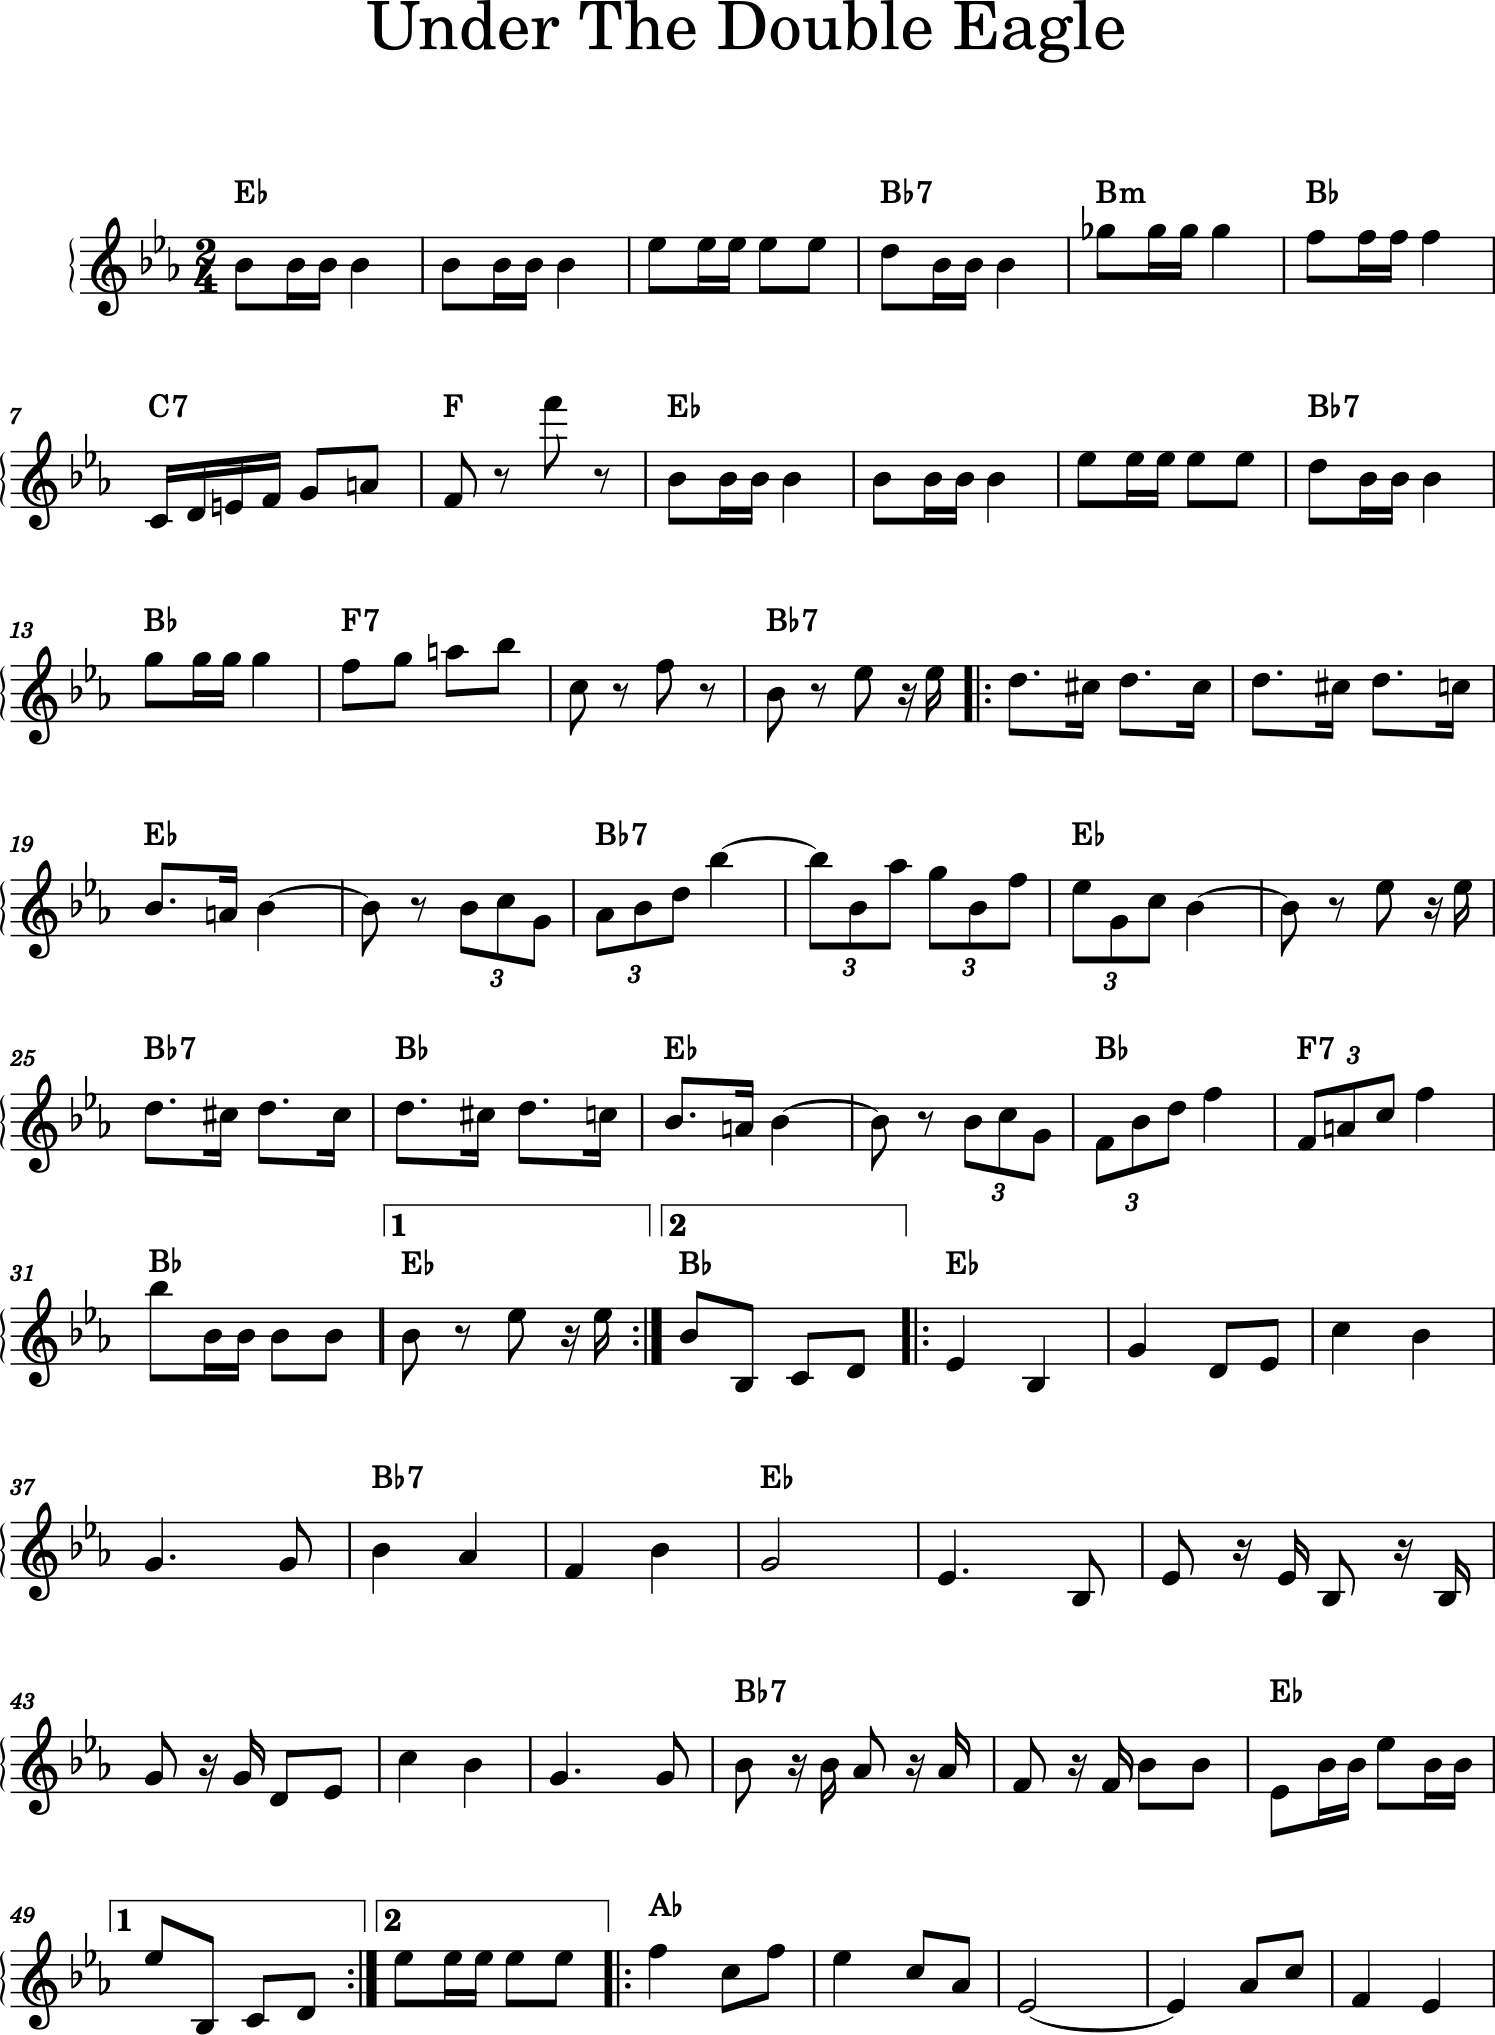

dlopen error : dlopen(libjack.0.dylib, 0x0001): tried: 'libjack.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibjack.0.dylib' (no such file), '/Applications/MuseScore 3.app/Contents/Frameworks/libjack.0.dylib' (no such file), '/Applications/MuseScore 3.app/Contents/Frameworks/libjack.0.dylib' (no such file), '/usr/lib/libjack.0.dylib' (no such file, not in dyld cache), 'libjack.0.dylib' (no such file), '/usr/lib/libjack.0.dylib' (no such file, not in dyld cache) 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 0x0001): tried: '/usr/local/lib/libjack.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/lib/libjack.0.dylib' (no such file), '/usr/local/lib/libjack.0.dylib' (no such file) 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/dm/6wgj6qbx79j95xwrmxfmlmqh0000gn/T/music21/tmp987nqcf4.xml>...
JIT is disabled for QML. Property bindings 

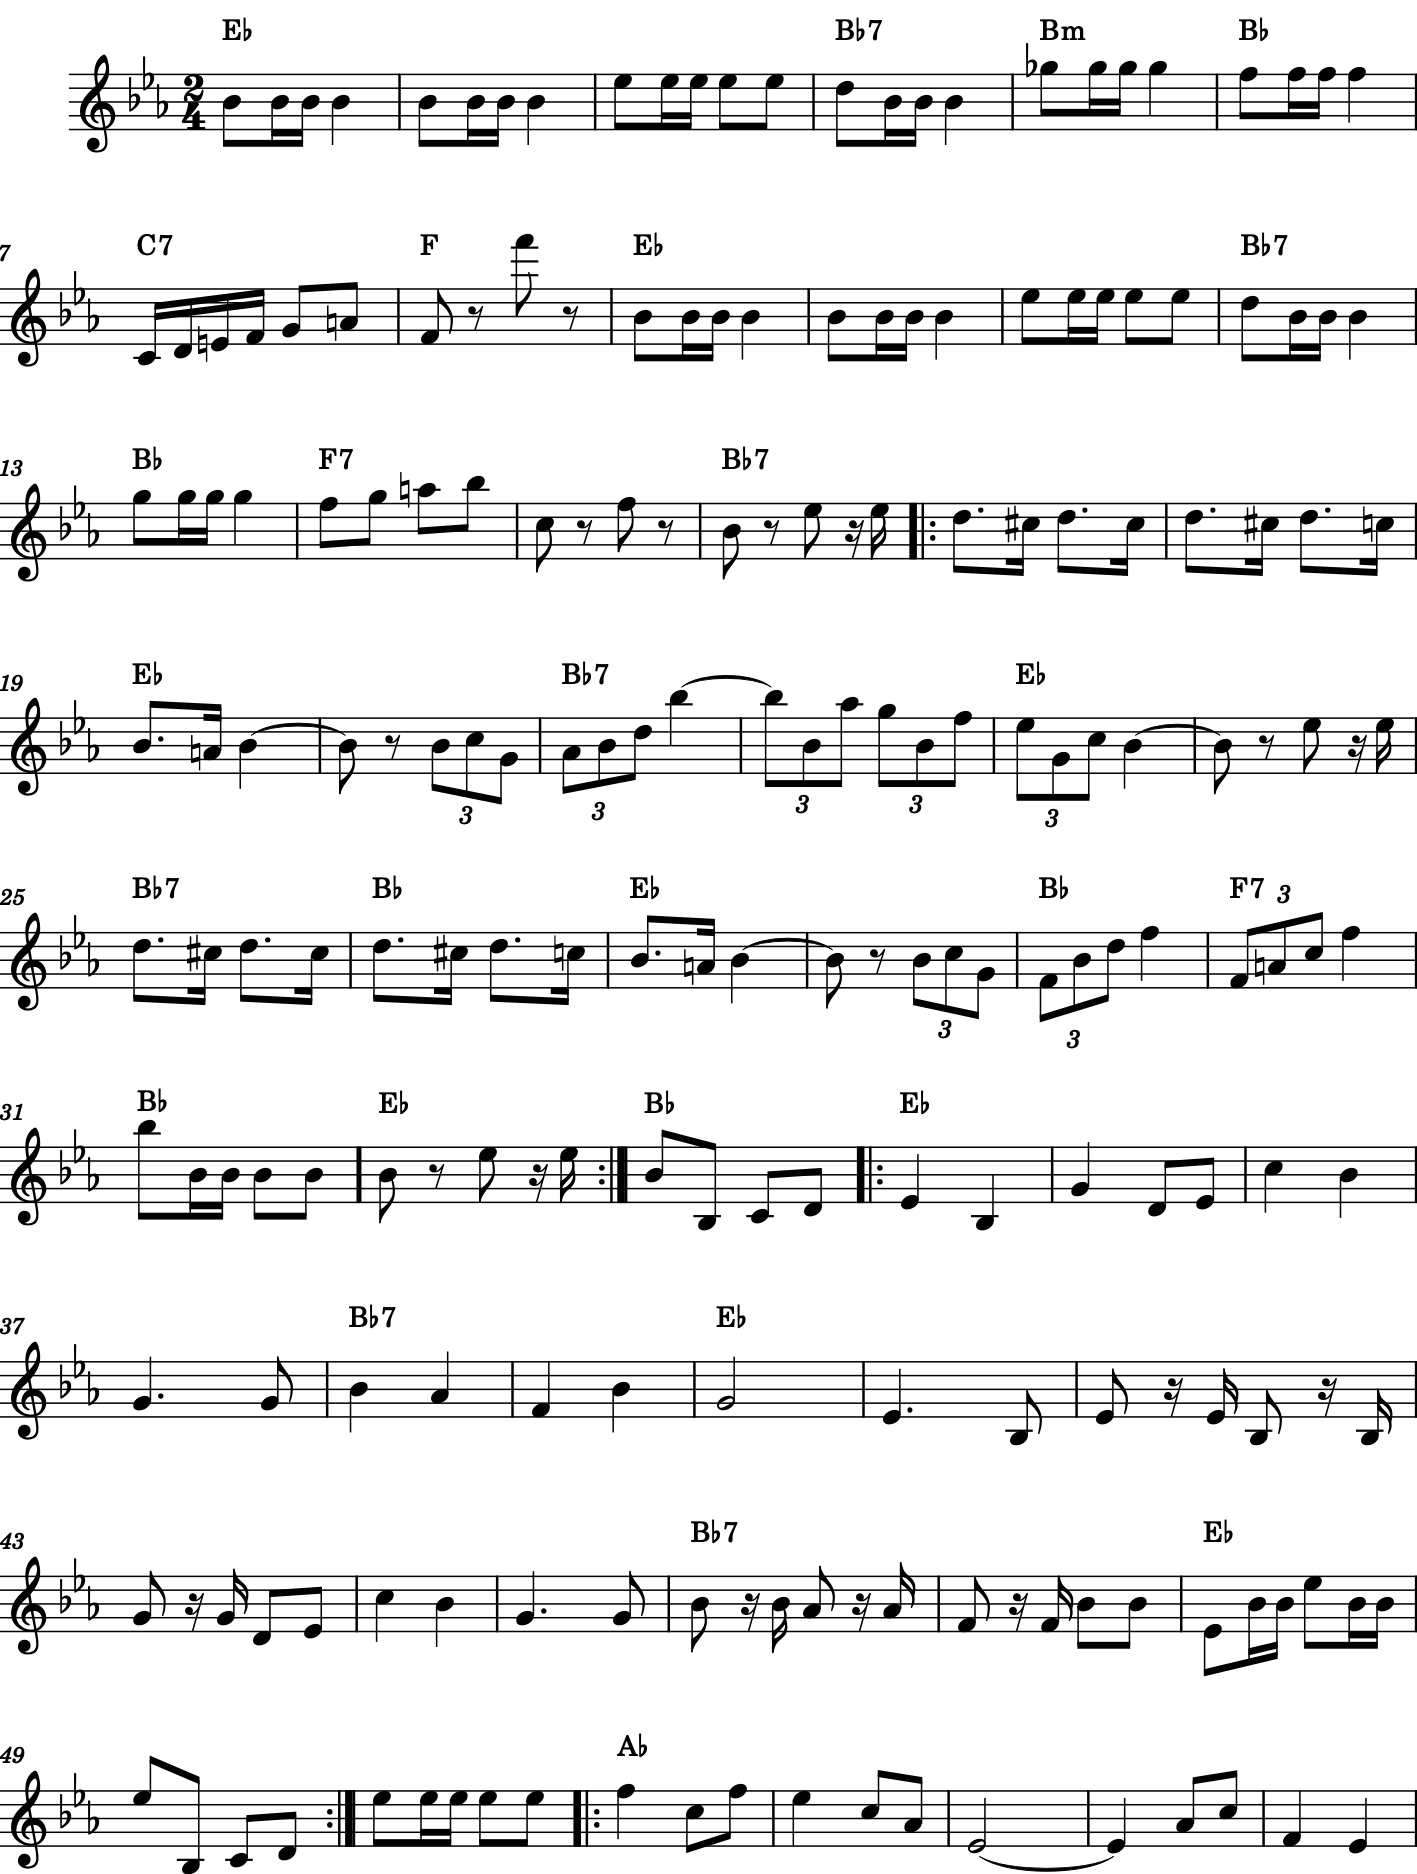

In [7]:
songs[72].show()

fixed_songs_v2[72].show()

In [8]:
# final step of preprocessing: if measure has no chord, grab last chord from previous measure 

for songNum,song in enumerate(fixed_songs_v2):
    measures = song.getElementsByClass(stream.Measure)
    for i,m in enumerate(measures):
        chords = m.getElementsByClass("ChordSymbol")

        timeSig = song.flat.timeSignature
        if len(chords) == 0 and i != 0:
            # get previous measure's last chord 
            previousMeasure = measures[i-1]
            previousMeasureLastChord = previousMeasure.getElementsByClass("ChordSymbol")[-1]
            
            chordCopy = copy.deepcopy(previousMeasureLastChord)
            chordCopy2 = copy.deepcopy(previousMeasureLastChord)
            m.insert(0,chordCopy)
            if timeSig.ratioString != "2/4":
                m.insert(2.0,chordCopy2)
        
        elif len(chords) == 1 and timeSig.ratioString != "2/4":
            print("this shouldn't happen!")
            print(songNum,i)
            



this shouldn't happen!
1133 1
this shouldn't happen!
1133 3
this shouldn't happen!
1133 4
this shouldn't happen!
1133 6
this shouldn't happen!
1133 8
this shouldn't happen!
1133 10
this shouldn't happen!
1133 12
this shouldn't happen!
1133 13
this shouldn't happen!
1133 14
this shouldn't happen!
1133 15
this shouldn't happen!
1133 16
this shouldn't happen!
1133 26
this shouldn't happen!
1133 30
this shouldn't happen!
1133 34
this shouldn't happen!
1133 36
this shouldn't happen!
1133 39
this shouldn't happen!
1133 41
this shouldn't happen!
1133 55
this shouldn't happen!
1133 59
this shouldn't happen!
1133 63
this shouldn't happen!
3690 29


In [9]:
# fix one edge case song 
measures = fixed_songs_v2[1133].getElementsByClass(stream.Measure)
for i,m in enumerate(measures):
    chords = m.getElementsByClass("ChordSymbol")
    if len(chords) == 1:
        chordCopy = copy.deepcopy(chords[-1])

        m.insert(2.0,chordCopy)

# delete song with 'No Chord' symbol
del fixed_songs_v2[3690]

In [10]:
# final check of songs
for songNum, song in enumerate(fixed_songs_v2):

    measures = song.getElementsByClass(stream.Measure)
    timeSig = song.flat.timeSignature
    for i,m in enumerate(measures):
        chords = m.getElementsByClass("ChordSymbol")
        if len(chords) == 1 and timeSig.ratioString != "2/4":
            print("this shouldn't happen ahh!")
            print(songNum,i)

In [12]:
# change as desired
folderPath = "/Users/antonischristou/Desktop/Melody Harmonization/wikifonia corrected/"
for i,song in enumerate(fixed_songs_v2):
    savePath = folderPath+str(i)
    song.write(fp=savePath)